# EXPERIMENT 2: Adding Fully Connected Layer

YOLOv1 is an object detection model that consists of a convolutional neural network followed by several fully connected layers at the end of the network. 

The fully connected layers in YOLOv1 are responsible for mapping the output of the convolutional layers to the final output of the model, which is the predicted bounding boxes and class probabilities for the objects in the image.

Possible effects of adding more fully connected layers: 

- **Improved accuracy**: Adding more fully connected layers could potentially improve the accuracy of the model by allowing it to learn more complex representations of the input image.

- **Increased computational complexity**: Adding more fully connected layers will increase the number of parameters in the model, which will increase the computational complexity of the model and require more memory and processing power.

- **Overfitting**: If the added layers are not carefully designed and trained, they could lead to overfitting, where the model becomes too complex and memorizes the training data rather than generalizing to new data.

In [1]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from dataset import AfricanWildlifeDataset
from loss import YoloLoss
from YOLOv1 import YOLO
from train import train
from test import test
from utils import plot_bbox, compute_ap, get_boxes
import time

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 5
EPOCHS = 10
TRAIN_DIR = 'African_Wildlife/train'
TEST_DIR = 'African_Wildlife/test'
LABEL_DIR = 'African_Wildlife/annotations'
S, B, C = 7, 2, 4

In [3]:
# load the data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(), transforms.Normalize([0.5200, 0.4957, 0.4068],[0.2391, 0.2283, 0.2303])])

train_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, transform=transform)
train_loader = DataLoader(dataset = train_set, batch_size = TRAIN_BATCH_SIZE, shuffle = True)

test_set = AfricanWildlifeDataset(TRAIN_DIR, TEST_DIR, LABEL_DIR, S=S, B=B, C=C, istesting=True, transform=transform)
test_loader = DataLoader(dataset=test_set, batch_size=TEST_BATCH_SIZE, shuffle= False)

# 1. Two Fully Connected Layer

## 1.1. Training 

In [21]:
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [22]:
start_time = time.time()
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='experiment_1/two_fc.tar', load_model=False, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 


100%|██████████| 60/60 [00:29<00:00,  2.03it/s, loss=0.127] 


 EPOCH 1:  Mean loss 0.187


100%|██████████| 60/60 [00:28<00:00,  2.09it/s, loss=0.15]  


 EPOCH 2:  Mean loss 0.120


100%|██████████| 60/60 [00:28<00:00,  2.09it/s, loss=0.115] 


 EPOCH 3:  Mean loss 0.104


100%|██████████| 60/60 [00:28<00:00,  2.08it/s, loss=0.0983]


 EPOCH 4:  Mean loss 0.092


100%|██████████| 60/60 [00:29<00:00,  2.06it/s, loss=0.0685]


 EPOCH 5:  Mean loss 0.080
-> Saving checkpoint


100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.0655]


 EPOCH 6:  Mean loss 0.068


100%|██████████| 60/60 [00:28<00:00,  2.09it/s, loss=0.0668]


 EPOCH 7:  Mean loss 0.060


100%|██████████| 60/60 [00:28<00:00,  2.08it/s, loss=0.0541]


 EPOCH 8:  Mean loss 0.051


100%|██████████| 60/60 [00:29<00:00,  2.05it/s, loss=0.0314]


 EPOCH 9:  Mean loss 0.044


100%|██████████| 60/60 [00:28<00:00,  2.09it/s, loss=0.0403]


 EPOCH 10:  Mean loss 0.037
-> Saving checkpoint
Elapsed time:  294.518274307251


Text(0, 0.5, 'Loss')

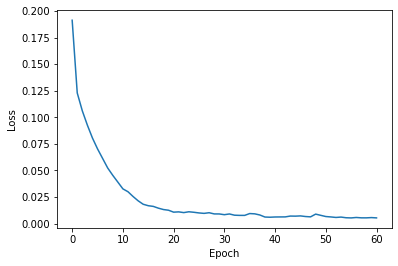

In [63]:
plt.plot(range(len(loss_hist)), loss_hist) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")

## 1.2. Testing

In [64]:
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.60, True])

In [ ]:
color_map = {'buffalo': "red", 'elephant': "blue", 'rhino': "yellow", 'zebra': "green"}

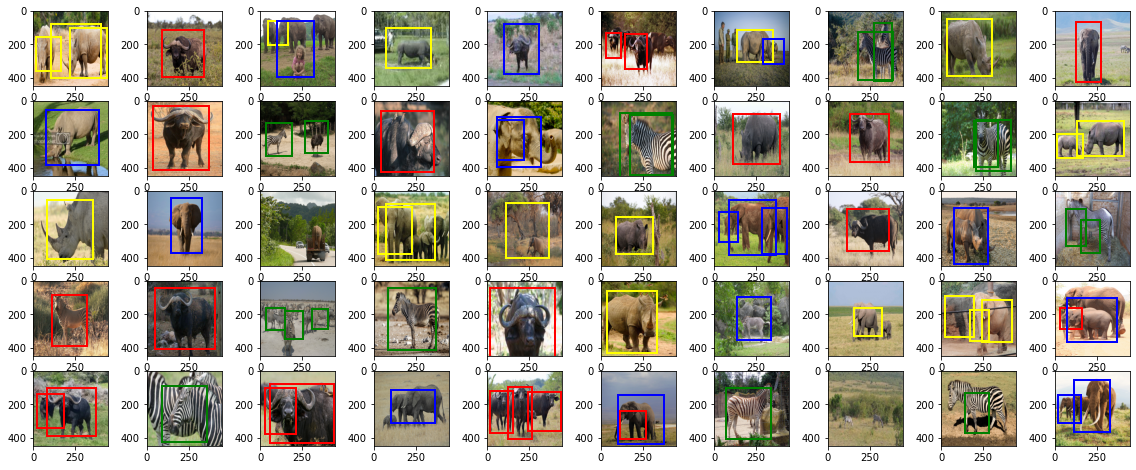

In [65]:
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
for idx in range(50):
    bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

### 1.2.1. Non-max-suppression

In [66]:
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

In [67]:
pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

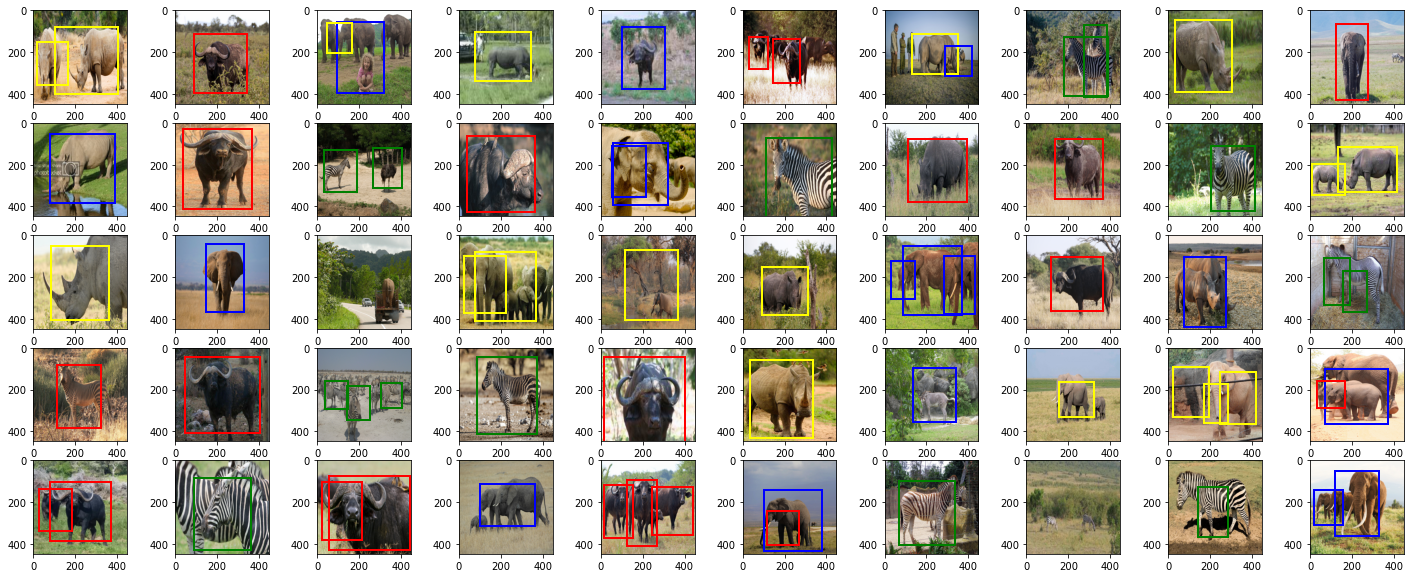

In [68]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

In [69]:
gt = {}
gt = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in true_boxes:
    gt[box[0]].append(box[1:])

## 1.3. Mean average precision

In [70]:
def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [71]:
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

In [72]:
th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)

In [73]:
m_ap.update(predictions, target)
ap2 = m_ap.compute()

In [74]:
ap2

{'map': tensor(0.1443),
 'map_50': tensor(0.3337),
 'map_75': tensor(0.1037),
 'map_small': tensor(0.1443),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.2047),
 'mar_10': tensor(0.2291),
 'mar_100': tensor(0.2291),
 'mar_small': tensor(0.2291),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

# 2. Three Fully Connected Layers

## 2.1. Training 

In [23]:
model = YOLO(input_channels=3, S=S, B=B, C=C, fc=3).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = YoloLoss(S=S, B=B, C=C)

In [24]:
start_time = time.time()
loss_hist = train(train_loader, model, optimizer, criterion, EPOCHS, DEVICE, 
                  ckpt_filename='experiment_1/three_fc.tar', load_model=False, 
                  save_epochs=5)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time) 


100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.139] 


 EPOCH 1:  Mean loss 0.202


100%|██████████| 60/60 [00:28<00:00,  2.08it/s, loss=0.148] 


 EPOCH 2:  Mean loss 0.132


100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.12]  


 EPOCH 3:  Mean loss 0.119


100%|██████████| 60/60 [00:29<00:00,  2.05it/s, loss=0.122] 


 EPOCH 4:  Mean loss 0.107


100%|██████████| 60/60 [00:28<00:00,  2.08it/s, loss=0.0932]


 EPOCH 5:  Mean loss 0.095
-> Saving checkpoint


100%|██████████| 60/60 [00:29<00:00,  2.07it/s, loss=0.0916]


 EPOCH 6:  Mean loss 0.084


100%|██████████| 60/60 [00:29<00:00,  2.06it/s, loss=0.0978]


 EPOCH 7:  Mean loss 0.076


100%|██████████| 60/60 [00:29<00:00,  2.04it/s, loss=0.0721]


 EPOCH 8:  Mean loss 0.066


100%|██████████| 60/60 [00:29<00:00,  2.07it/s, loss=0.0687]


 EPOCH 9:  Mean loss 0.057


100%|██████████| 60/60 [00:28<00:00,  2.07it/s, loss=0.045] 


 EPOCH 10:  Mean loss 0.051
-> Saving checkpoint
Elapsed time:  297.01254868507385


Text(0, 0.5, 'Loss')

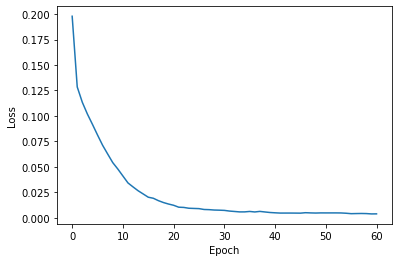

In [77]:
plt.plot(range(len(loss_hist)), loss_hist) # trained for 60 epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")

## 2.2. Testing

In [78]:
y_pred, y_true = test(test_loader, model, DEVICE, filter_params=[0.60, True])

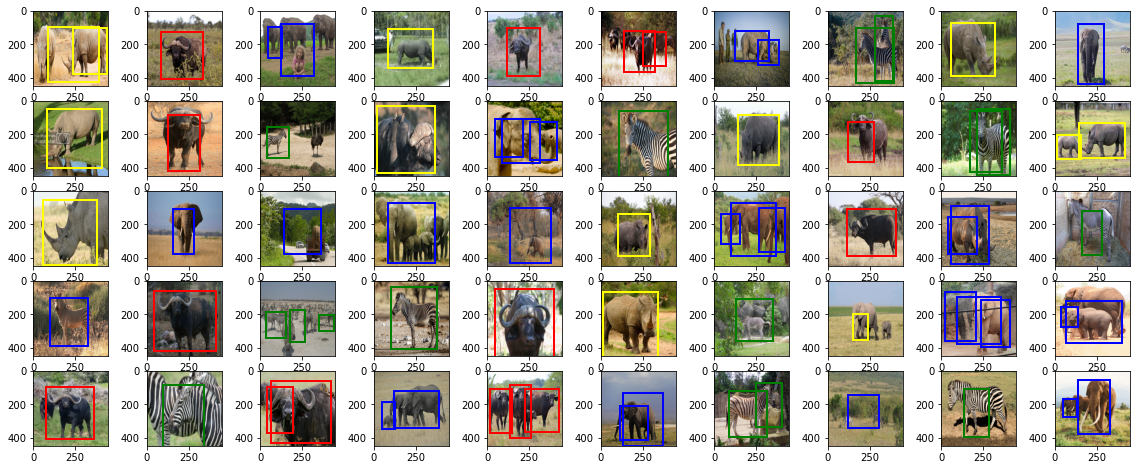

In [79]:
fig, ax = plt.subplots(5, 10, figsize=(20, 8))
for idx in range(50):
    bbx = y_pred[idx, y_pred[idx, ::, 1] > 0]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

### 2.2.1. Non-max-suppression

In [80]:
pred_boxes, true_boxes = get_boxes(y_pred, y_true)

In [81]:
pred = {}
pred = {idx: [] for idx in range(len(test_loader) * TEST_BATCH_SIZE)}
for box in pred_boxes:
    pred[box[0]].append(box[1:])

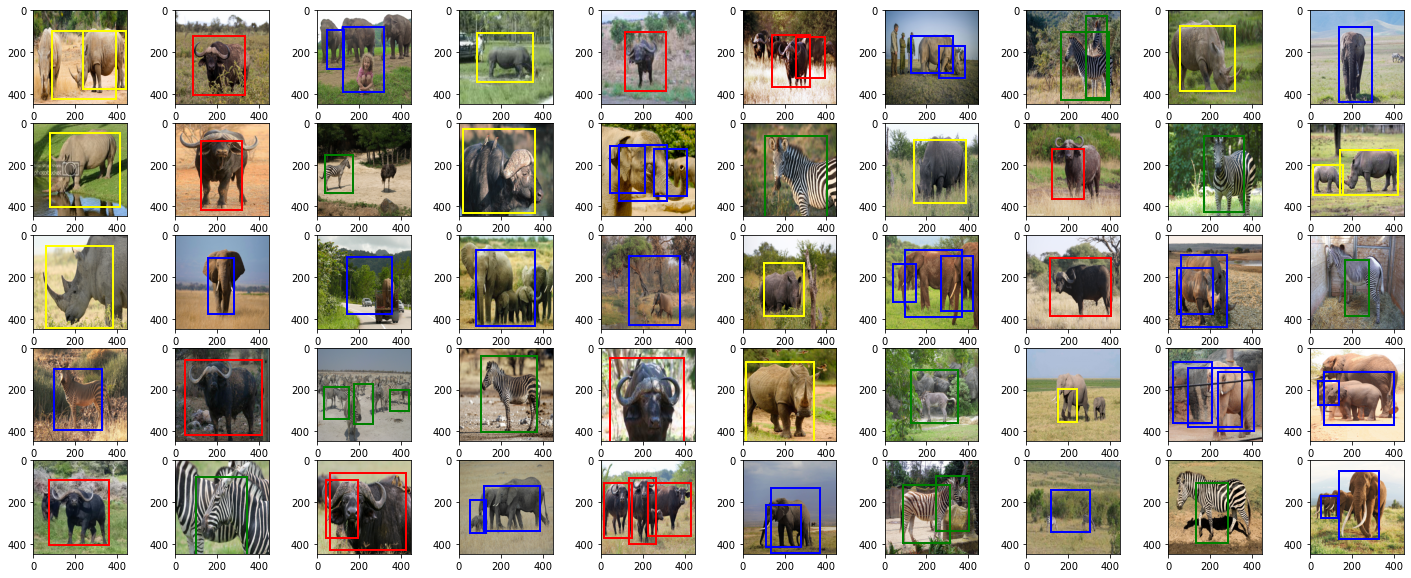

In [82]:
fig, ax = plt.subplots(5, 10, figsize=(25, 10))
for idx in range(50):
    bbx = pred[idx]
    plot_bbox(idx, test_set, bbx, ax=ax.flatten()[idx])

## 2.3. Mean average precision

In [83]:
def convert_dict(d, with_score=True):
    boxes_by_img = []
    for key, val in d.items():
        l = {}
        l['boxes'] = torch.tensor([x[2:] for x in val])
        if with_score:
            l['scores'] = torch.tensor([x[1] for x in val])
        l['labels'] = torch.tensor([int(x[0]) for x in val])
        boxes_by_img.append(l)
    return boxes_by_img

In [84]:
predictions = convert_dict(pred)
target = convert_dict(gt, with_score=False)

In [85]:
th = torch.arange(0.5, 1, 0.05).tolist()
m_ap = MeanAveragePrecision(box_format='xywh', iou_type="bbox", iou_thresholds=th)

In [86]:
m_ap.update(predictions, target)
ap3 = m_ap.compute()

In [87]:
ap3

{'map': tensor(0.1372),
 'map_50': tensor(0.3508),
 'map_75': tensor(0.0966),
 'map_small': tensor(0.1372),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.2020),
 'mar_10': tensor(0.2407),
 'mar_100': tensor(0.2407),
 'mar_small': tensor(0.2407),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [26]:
fc2 = torch.load('experiment_1/two_fc.tar')
loss_history2 = fc2["loss_history"]
epoch2 = fc3["epoch"]

fc3 = torch.load('experiment_1/three_fc.tar')
loss_history3 = fc3["loss_history"]

epochs = [i for i in range(1,epoch2+1)]

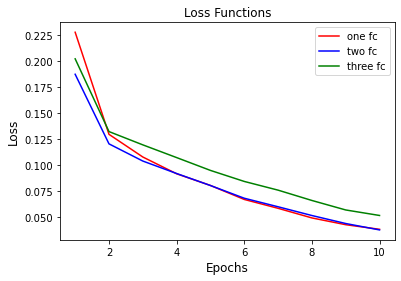

In [33]:
import matplotlib.pyplot as plt

plt.plot(epochs, loss_history2, 'b-', label='two fc')
plt.plot(epochs, loss_history3, 'r-', label='three fc')
plt.legend(loc='best')
plt.title('Loss Functions')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()